In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
try:
    import pcmdpy_gpu as ppy
except:
    import pcmdpy as ppy
from tqdm import tqdm
plt.style.use('seaborn-poster')
%matplotlib inline

In [2]:
filters = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(filters, mag_system='ab')
driv = ppy.driver.Driver(iso_model, gpu=ppy.gpu_utils._GPU_ACTIVE)

In [3]:
gal = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.SingleFeH(), 
    ppy.dustmodels.SingleDust(dust_frac=0.5),
    ppy.sfhmodels.TauModel(iso_step=.2),
    ppy.distancemodels.VariableDistance(),
)

In [22]:
p = {}
p[0] = np.array([-0.5, -0.5, 3.0, 3.0, 25.0])
p[1] = p[0] + np.array([0.5, 0., 0., 0., 0.])
p[2] = p[0] + np.array([-0.5, 0., 0., 0., 0.])
p[3] = p[0] + np.array([0., 0.5, 0., 0., 0.])
p[4] = p[0] + np.array([0., -0.5, 0., 0., 0.])
p[5] = p[0] + np.array([0., 0., 0., 9.0, 0.])
p[6] = p[0] + np.array([0., 0., 0., -2.0, 0.])
p[7] = p[0] + np.array([0., 0., 0.5, 0., 0.])
p[8] = p[0] + np.array([0., 0., -0.5, 0., 0.])
p[9] = p[0] + np.array([0., 0., 0., 0., -1.25])
p[10] = p[0] + np.array([0., 0., 0., 0., +1.25])

In [23]:
if ppy.gpu_utils._GPU_ACTIVE:
    Nim = 1024
else:
    Nim = 128
pcmds = {}
for i in tqdm(range(0, 11)):
    gal.set_params(p[i])
    pcmds[i] = driv.simulate(gal, Nim, shot_noise=False)[0]

100%|██████████| 11/11 [02:36<00:00, 14.24s/it]


In [39]:
titles = {}
titles[0] = 'Baseline Model'
titles[1] = '[Fe/H] + 0.5'
titles[2] = '[Fe/H] - 0.5'
titles[3] = '$\log$ E(B-V) + 0.5'
titles[4] = '$\log$ E(B-V) - 0.5'
titles[5] = r'$\tau$ x 3'
titles[6] = r'$\tau$ x 1/3'
titles[7] = r'$\log \mathrm{N_{pix}}$ + 0.5'
titles[8] = r'$\log \mathrm{N_{pix}}$ - 0.5'
titles[9] = r'$\mu$ - 1.25'
titles[10] = r'$\mu$ + 1.25'

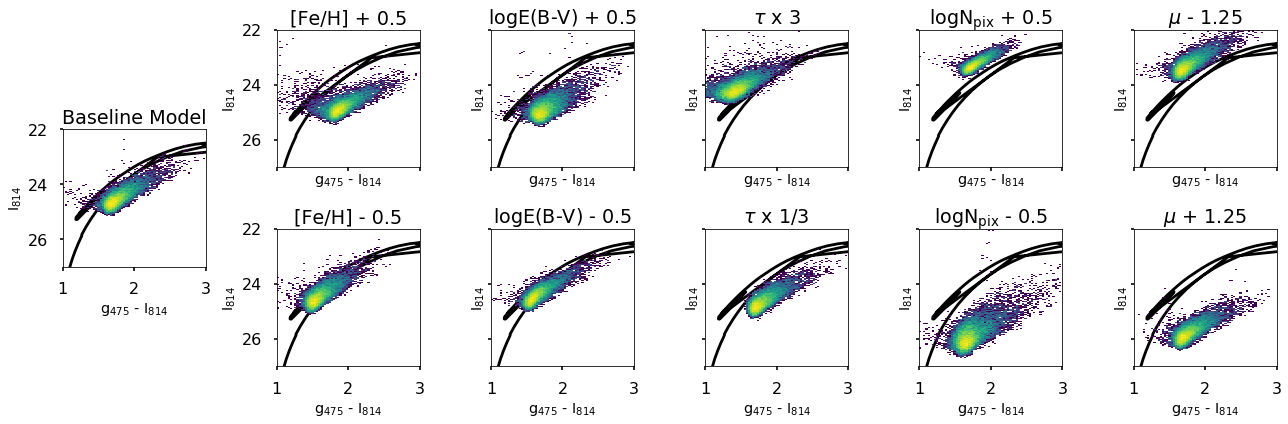

In [44]:
f = plt.figure(figsize=(18, 6))
gs = mpl.gridspec.GridSpec(200, 6)
axes = []
axes.append(f.add_subplot(gs[50:150, 0]))
axes.append(f.add_subplot(gs[:100, 1], sharex=axes[0], sharey=axes[0]))
axes.append(f.add_subplot(gs[100:, 1], sharex=axes[0], sharey=axes[0]))
axes.append(f.add_subplot(gs[:100, 2], sharex=axes[0], sharey=axes[0]))
axes.append(f.add_subplot(gs[100:, 2], sharex=axes[0], sharey=axes[0]))
axes.append(f.add_subplot(gs[:100, 3], sharex=axes[0], sharey=axes[0]))
axes.append(f.add_subplot(gs[100:, 3], sharex=axes[0], sharey=axes[0]))
axes.append(f.add_subplot(gs[:100, 4], sharex=axes[0], sharey=axes[0]))
axes.append(f.add_subplot(gs[100:, 4], sharex=axes[0], sharey=axes[0]))
axes.append(f.add_subplot(gs[:100, 5], sharex=axes[0], sharey=axes[0]))
axes.append(f.add_subplot(gs[100:, 5], sharex=axes[0], sharey=axes[0]))

bins = [np.arange(22, 27, 0.03), np.arange(1, 3, 0.03)]

for i, a in enumerate(axes):
    ppy.plotting.plot_pcmd(pcmds[i], ax=a, bins=bins)
    ppy.plotting.plot_isochrone(iso_model, dmod=25.0, axes=a, zorder=-1)
    a.set_aspect('auto')
    a.set_title(f'Plot {i}')
    if i > 2:
        plt.setp(a.get_yticklabels(), visible=False)
    if (i % 2):
        plt.setp(a.get_xticklabels(), visible=False)
    a.set_title(titles[i])

axes[0].set_xlim([1, 3])
axes[0].set_ylim([27, 22])
plt.tight_layout()
if ppy.gpu_utils._GPU_ACTIVE:
    plt.savefig('figures/paper1_paramvariance.pdf')